Original: https://www.kaggle.com/alexkaechele/women-s-world-cup-2019-predictions/code

# Women' World Cup 2019 Predictions

![](https://worldsoccertalk.com/wp-content/uploads/2018/09/womens-world-cup-teams.jpg)
## Setup

Here I load in previous games. Given the lack of women's national team data, I inputed the game scores manually. The tournaments that I included were:
- World Cup Qualifiers
- Olympics (2016)
- She Believes Cup (2019, 2018, 2017)
- UEFA Womens Championship (2017)
- FFA Cup of Nations (2019)

In [2]:
# Load packages
import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import random


# Load wc qualifying data
df = pd.read_csv("womens_world_cup_data.csv")

# Load fifa rankings
dat = pd.read_csv("womens_world_cup_rankings.csv")



## Formatting qualifying data
df['date'] = df['date'].str.replace('ÿ', ' ')
df['date'] = pd.to_datetime(df['date'])

# Filter to needed columns and rename
df = df.rename(columns={'Team_i'  : 'teami',
                        'score_i' : 'scorei',
                        'Team_j'  : 'teamj', 
                        'score_j' : 'scorej',
                        'home_i'  : 'homei',
                        'home_j'  : 'homej'})

# Create margin
df['margin'] = df.scorei - df.scorej



## Formatting ranking data
dat["team"] = dat["team"].str.lower()
dat = dat.loc[dat.team.isin(df.teami.append(df.teamj))]

# Making fifa ranking mean 0 sd .5
dat["ranking"] = (dat.rating - dat.rating.mean())/np.std(dat.rating)/2
# merge with df (need to add to final dataset)

# List of womens world cup teams and rankings
fifarnk = pd.DataFrame({"team" : ["france", "norway", "south korea", "nigeria", "germany", "spain", "china", "south africa", "australia", "brazil", "italy", "jamaica",
                                  "england", "japan", "scotland", "argentina", "canada", "netherlands", "new zealand", "cameroon", "united states", "sweden", "thailand", "chile"],
                         "ranking" : [3, 13, 14, 39, 2, 12, 15, 48, 6, 10, 16, 53, 4, 8, 20, 36, 5, 7, 19, 46, 1, 9, 29, 38] })




## Set up team id mapping
team_key = pd.DataFrame({"teamname" : df.teami.append(df.teamj).unique(),
                         "teamid"   : range(1, 1+len(df.teami.append(df.teamj).unique()))})

# Recoding ids in qualifying data
df = df.merge(team_key, left_on="teami" , right_on="teamname")
df = df.drop(columns=["teamname", "teami"])
df = df.rename(index = str, columns = {"teamid" : "teami"})

df = df.merge(team_key, left_on="teamj" , right_on="teamname")
df = df.drop(columns=["teamname", "teamj"])
df = df.rename(index = str, columns = {"teamid" : "teamj"})

# Recoding ids in ranking data
dat = dat.merge(team_key, left_on="team" , right_on="teamname")
dat = dat.drop(columns=["teamname"])



# Final dataset for modeling
names = ["N", "y", "h_i", "h_j", "team_i", "team_j", "N_g"]
values = [len(df.index), df.margin, df.homei, df.homej, df.teami, df.teamj, 79]

train = dict(zip(names, values))

## Model Training

I used a Bayesian model that takes into consideration score margin and home and away.

In [3]:

model = """
data {
    int N;
    vector[N] y;
    int team_i[N];
    int team_j[N];
    int h_i[N];
    int h_j[N];
    int N_g;
}
parameters {
    vector[N_g] alpha_raw;
    vector[N_g] theta_raw;
    real eta;
    real<lower=0> tau_theta;
    real<lower=0> tau_alpha;
    real<lower=0> sigma;
}
transformed parameters {
    vector[N_g] alpha;
    vector[N_g] theta;
    alpha = eta + alpha_raw*tau_alpha;
    theta = theta_raw*tau_theta;
}
model {
    // vector for conditional mean storage
    vector[N] mu;

    // priors
    tau_theta ~ cauchy(0,1)T[0,];
    tau_alpha ~ cauchy(0,.25)T[0,];
    sigma ~ cauchy(0,1)T[0,];
    eta ~ normal(.5,.25);
    theta_raw ~ normal(0,1);
    alpha_raw ~ normal(0,1);

    // define mu for the Gaussian
    for( t in 1:N ) {
    mu[t] = (theta[team_i[t]] + alpha[team_i[t]]*h_i[t]) - 
    (theta[team_j[t]] + alpha[team_j[t]]*h_j[t]);
}

    // the likelihood
    y ~ normal(mu,sigma);
}
"""

sm = pystan.StanModel(model_code = model)
fit = sm.sampling(data = train, 
                  iter = 1500, 
                  warmup = 750,
                  refresh = 100,
                  control = dict(adapt_delta = 0.9))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_42cb73da1cde31201ff6a552a9c0c42e NOW.


## Team Rankings

Here is a look at the ranking of the top 25 teams according to my model

Text(0, 0.5, 'Teams')

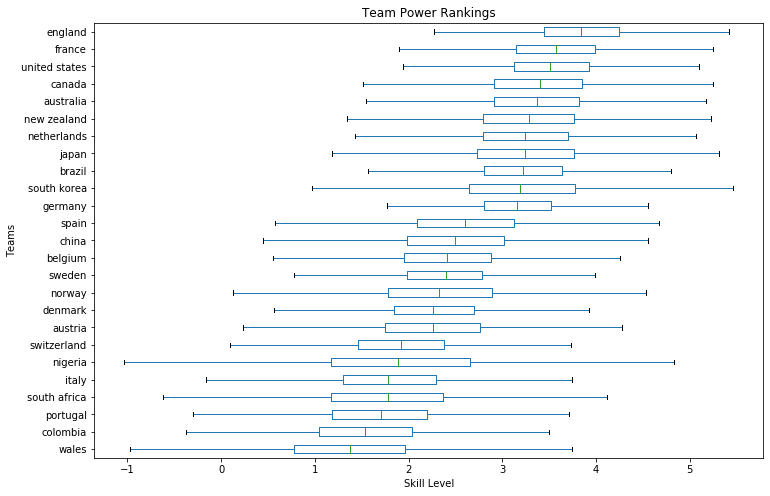

In [4]:
# Extracting team skill levels
th = pd.DataFrame(fit.extract()["theta"])
a = pd.DataFrame(fit.extract()["alpha"])
sig = fit.extract()["sigma"]
a.columns = team_key.teamname
th.columns = team_key.teamname

# Filtering to top 25 teams
theta25 = th[th.median().nlargest(25).index]
theta25 = theta25[theta25.columns[::-1]]

# Creating the plot
theta25.boxplot(grid = False, vert = False, showfliers = False, figsize=(12, 8))
plt.title('Team Power Rankings')
plt.xlabel('Skill Level')
plt.ylabel('Teams')

## Function Building

Here are functions useful in predicting the world cup.

In [17]:
def compare(i, j, homei = 0, homej = 0, th= th, a = a, sig = sig, reps = 1000, allowdraw = False):
    if allowdraw:
        win_prob = []
        draw_prob = []
        
        # Simulating specified number of games
        for r in range(1, reps):
            win_prob.append(
                np.mean(
                    
                    # Ability difference
                    th[i].sample(1).values - th[j].sample(1).values + 
                    
                    # Home field advantage
                    a[i].sample(1).values*homei - a[j].sample(1).values*homej
                    ) > 0
                )
         
        # Averaging game results
        win_prob = np.mean(win_prob)
        
        # Displaying results
        print(i + " has a " + str(round(win_prob*100, 2)) + "% chance of beating " + j)
    
    else:
        win_prob = []
        
        # Simulating specified number of games
        for r in range(1, reps):
            win_prob.append(
                np.mean(
                    
                    # Ability difference
                    th[i].sample(1).values - th[j].sample(1).values + 
                    
                    # Home field advantage
                    a[i].sample(1).values*homei - a[j].sample(1).values*homej
                    ) > 0
                )
         
        # Averaging game results
        win_prob = np.mean(win_prob)
        
        # Displaying results
        print(i + " has a " + str(round(win_prob*100, 2)) + "% chance of beating " + j)
    
    
def short_compare(i, j, homei, homej, th= th, a = a, sig = sig, allowdraw = True):
    
    gamescore = th[i].sample(1).values - th[j].sample(1).values + a[i].sample(1).values*homei - a[j].sample(1).values*homej
    
    if(allowdraw):
        if(abs(gamescore) < 1):
            return([1, 1])
        if(gamescore > 0):
            return([3, 0])        
        else:
            return([0, 3])
    
    else:
        if(gamescore > 0):
            return([3, 0])
        else:
            return([0, 3])

def group_sim_short(i, j, k, l, homei, homej, homek, homel, th= th, a = a, sig = sig):

    # Initial values
    score_i, score_j, score_k, score_l = 0, 0, 0, 0
    
    # Round robin games
#     score_i, score_j = [score_i, score_j] + np.array(short_compare(i, j, homei, homej))
#     score_i, score_k = [score_i, score_k] + np.array(short_compare(i, k, homei, homek))
#     score_i, score_l = [score_i, score_l] + np.array(short_compare(i, l, homei, homel))
#     score_j, score_k = [score_j, score_k] + np.array(short_compare(j, k, homej, homek))
#     score_j, score_l = [score_j, score_l] + np.array(short_compare(j, l, homej, homel))
#     score_k, score_l = [score_k, score_l] + np.array(short_compare(k, l, homek, homel))
    
    points_defined = {
        'france,norway,south korea,nigeria': [9,6,0,3],
        'germany,spain,china,south africa': [9,4.1,4,0],
        'australia,brazil,italy,jamaica': [6.1,6,6.2,0],
        'england,japan,scotland,argentina': [9,4,1,2],
        'canada,netherlands,new zealand,cameroon': [6,9,0,3],
        'united states,sweden,thailand,chile': [9,6,0,3],
    }
    
    # Determining winners
    teams = [i, j, k, l]
    d = {'teams': teams, 'points': points_defined[",".join(teams)]}
    df = pd.DataFrame(data=d)
    df.sort_values(by=["points"], inplace=True, ascending=False)
    df.index = np.arange(1, len(df) + 1)
    df["ranking"] = df.index    
    
    return(df)

def group_sim(i, j, k, l, homei, homej, homek, homel, th= th, a = a, sig = sig, reps = 1000):

    df = pd.DataFrame()
    
    for r in range(1, reps):
        
        # Simulate games
        df_temp = group_sim_short(i, j, k, l, homei, homej, homek, homel)
        df = df.append(df_temp)
        
    # Average points in season
    dat = pd.DataFrame(df.groupby("teams").points.mean()).reset_index()
    
    # Count of Rankings
    df["first"] = (df.ranking == 1)
    df["second"] = (df.ranking == 2)
    df["third"] = (df.ranking == 3)
    df["fourth"] = (df.ranking == 4)
    
    # Percents
    dat = dat.merge(pd.DataFrame(df.groupby('teams')["first"].sum()/reps*100).reset_index(), on="teams")
    dat = dat.merge(pd.DataFrame(df.groupby('teams')["second"].sum()/reps*100).reset_index(), on="teams")
    dat = dat.merge(pd.DataFrame(df.groupby('teams')["third"].sum()/reps*100).reset_index(), on="teams")
    dat = dat.merge(pd.DataFrame(df.groupby('teams')["fourth"].sum()/reps*100).reset_index(), on="teams")
    
    # Sort by points
    dat = dat.sort_values(by=["points"], ascending=False)
    dat.index = np.arange(1, len(dat)+1)

    return(dat)

def choose_matchup(inputs):
    
    inputs1 = inputs.group.sort_values().tolist()
    
    if inputs1 == ["A", "B", "C", "D"]:
        output = [inputs[inputs.group == "B"]["team"].values[0], inputs[inputs.group == "C"]["team"].values[0], inputs[inputs.group == "A"]["team"].values[0], inputs[inputs.group == "D"]["team"].values[0]]
    elif inputs1 == ["A", "B", "C", "E"]:
        output = [inputs[inputs.group == "E"]["team"].values[0], inputs[inputs.group == "C"]["team"].values[0], inputs[inputs.group == "B"]["team"].values[0], inputs[inputs.group == "A"]["team"].values[0]]
    elif inputs1 == ["A", "B", "C", "F"]:
        output = [inputs[inputs.group == "F"]["team"].values[0], inputs[inputs.group == "C"]["team"].values[0], inputs[inputs.group == "B"]["team"].values[0], inputs[inputs.group == "A"]["team"].values[0]]
    elif inputs1 == ["A", "B", "D", "E"]:
        output = [inputs[inputs.group == "E"]["team"].values[0], inputs[inputs.group == "D"]["team"].values[0], inputs[inputs.group == "B"]["team"].values[0], inputs[inputs.group == "A"]["team"].values[0]]
    elif inputs1 == ["A", "B", "D", "F"]:
        output = [inputs[inputs.group == "F"]["team"].values[0], inputs[inputs.group == "D"]["team"].values[0], inputs[inputs.group == "B"]["team"].values[0], inputs[inputs.group == "A"]["team"].values[0]]
    elif inputs1 == ["A", "B", "E", "F"]:
        output = [inputs[inputs.group == "F"]["team"].values[0], inputs[inputs.group == "E"]["team"].values[0], inputs[inputs.group == "B"]["team"].values[0], inputs[inputs.group == "A"]["team"].values[0]]
    elif inputs1 == ["A", "C", "D", "E"]:
        output = [inputs[inputs.group == "E"]["team"].values[0], inputs[inputs.group == "C"]["team"].values[0], inputs[inputs.group == "A"]["team"].values[0], inputs[inputs.group == "D"]["team"].values[0]]
    elif inputs1 == ["A", "C", "D", "F"]:
        output = [inputs[inputs.group == "F"]["team"].values[0], inputs[inputs.group == "C"]["team"].values[0], inputs[inputs.group == "A"]["team"].values[0], inputs[inputs.group == "D"]["team"].values[0]]
    elif inputs1 == ["A", "C", "E", "F"]:
        output = [inputs[inputs.group == "E"]["team"].values[0], inputs[inputs.group == "C"]["team"].values[0], inputs[inputs.group == "F"]["team"].values[0], inputs[inputs.group == "A"]["team"].values[0]]
    elif inputs1 == ["A", "D", "E", "F"]:
        output = [inputs[inputs.group == "E"]["team"].values[0], inputs[inputs.group == "D"]["team"].values[0], inputs[inputs.group == "F"]["team"].values[0], inputs[inputs.group == "A"]["team"].values[0]]
    elif inputs1 == ["B", "C", "D", "E"]:
        output = [inputs[inputs.group == "E"]["team"].values[0], inputs[inputs.group == "C"]["team"].values[0], inputs[inputs.group == "B"]["team"].values[0], inputs[inputs.group == "D"]["team"].values[0]]
    elif inputs1 == ["B", "C", "D", "F"]:
        output = [inputs[inputs.group == "F"]["team"].values[0], inputs[inputs.group == "C"]["team"].values[0], inputs[inputs.group == "B"]["team"].values[0], inputs[inputs.group == "D"]["team"].values[0]]
    elif inputs1 == ["B", "C", "E", "F"]:
        output = [inputs[inputs.group == "F"]["team"].values[0], inputs[inputs.group == "E"]["team"].values[0], inputs[inputs.group == "B"]["team"].values[0], inputs[inputs.group == "C"]["team"].values[0]]
    elif inputs1 == ["B", "D", "E", "F"]:
        output = [inputs[inputs.group == "F"]["team"].values[0], inputs[inputs.group == "E"]["team"].values[0], inputs[inputs.group == "B"]["team"].values[0], inputs[inputs.group == "D"]["team"].values[0]]
    else:
        output = [inputs[inputs.group == "E"]["team"].values[0], inputs[inputs.group == "C"]["team"].values[0], inputs[inputs.group == "D"]["team"].values[0], inputs[inputs.group == "F"]["team"].values[0]]
    
    return(output)

This simulates the tournament 1000 times and aggregates the results, code to be tidied up in the future.

In [6]:
def tourn_sim(group, fifarnk = fifarnk, th= th, a = a, sig = sig, reps = 1000):
    # setting up final results
    results = pd.DataFrame({"team" : fifarnk.team, 
                            "grp4" : [0]*24, 
                            "grp3" : [0]*24, 
                            "rd16" : [0]*24, 
                            "quarters" : [0]*24, 
                            "semis" : [0]*24, 
                            "fourth" : [0]*24, 
                            "third" : [0]*24, 
                            "second" : [0]*24, 
                            "first" : [0]*24})
    
    for reps in range(0, reps):
                
        # Setting up group results
        grp = pd.DataFrame({"ranking" : [1,2,3,4]})
            
            
        # Simulate groups
        for ind in range(0, len(group.index)):
            grp_temp = group_sim_short(group.team1[ind],   group.team2[ind],   group.team3[ind],   group.team4[ind], 
                                       group.team1_h[ind], group.team2_h[ind], group.team3_h[ind], group.team4_h[ind])
            
            grp = grp.merge(grp_temp, on = "ranking", suffixes = ["", group.group[ind]])
        grp = pd.DataFrame(grp)
        
            
        # Recording 4th place teams
        done_teams = [grp.teams[3], grp.teamsB[3], grp.teamsC[3], grp.teamsD[3], grp.teamsE[3], grp.teamsF[3]]
        results.loc[results.team.isin(done_teams), "grp4"] += 1
        
        
        # Determing 3rd place advancers
        tie = grp[grp.ranking == 3]
        tie = pd.DataFrame({"team"   : [tie.teams[2], tie.teamsB[2], tie.teamsC[2], tie.teamsD[2], tie.teamsE[2], tie.teamsF[2]],
                            "group"  : ["A", "B", "C", "D", "E", "F"],
                            "points" : [tie.points[2], tie.pointsB[2], tie.pointsC[2], tie.pointsD[2], tie.pointsE[2], tie.pointsF[2]],
                            "fifa"   : [-fifarnk[fifarnk.team.isin(tie.teams)].ranking.values[0],
                                        -fifarnk[fifarnk.team.isin(tie.teamsB)].ranking.values[0],
                                        -fifarnk[fifarnk.team.isin(tie.teamsC)].ranking.values[0],
                                        -fifarnk[fifarnk.team.isin(tie.teamsD)].ranking.values[0],
                                        -fifarnk[fifarnk.team.isin(tie.teamsE)].ranking.values[0],
                                        -fifarnk[fifarnk.team.isin(tie.teamsF)].ranking.values[0]]})
    
        # Selecting 3rd place teams 
        tie = tie.sort_values(by=["points", "fifa"], ascending=False)
        tie.index = range(1,7)
        
        # Recording 3rd place, non-advancing teams
        done_teams = [tie.team[5], tie.team[6]]
        results.loc[results.team.isin(done_teams), "grp3"] += 1
        
        # Determining matchups of advanceing, 3rd place teams
        thirdplace = tie.iloc[0:4][["team", "group"]]
        thirdplace = choose_matchup(inputs=thirdplace)
    
        # Setting up round of 16
        rd16 = pd.DataFrame({"team1" : [grp.teams[1],  grp.teamsD[0], grp.teams[0], grp.teamsB[1], grp.teamsC[0], grp.teamsE[0], grp.teamsB[0], grp.teamsF[1]],
                             "team2" : [grp.teamsC[1], thirdplace[0], thirdplace[1], grp.teamsF[0], thirdplace[2], grp.teamsD[1], thirdplace[3], grp.teamsE[1]]})
        
        # Recording those who made rd of 16
        results.loc[results.team.isin(rd16.team1.append(rd16.team2)), "rd16"] += 1
        
        # Preparing round 16 playing
        winners = []
        losers = []
        
        # Playing rd 16
        for ind in range(0, 8):
            i  = rd16.team1[ind]
            j  = rd16.team2[ind]
            homei = (i=="france")
            homej = (j=="france")
            team1, team2 = short_compare(i, j, homei, homej, th= th, a = a, sig = sig, allowdraw = False)
            if (team1 == 3):
                winners.append(i)
            elif (team2 == 3):    
                winners.append(j)
        
        # Recording those who made quarters
        results.loc[results.team.isin(winners), "quarters"] += 1
        
        
        # Setting up quarters
        quarters = pd.DataFrame({"team1" : [winners[0], winners[2], winners[4], winners[6]],
                                 "team2" : [winners[1], winners[3], winners[5], winners[7]]})
        
        # Preparing quarters playing
        winners = []
        
        # Playing quarters
        for ind in range(0, 4):
            i  = quarters.team1[ind]
            j  = quarters.team2[ind]
            homei = (i=="france")
            homej = (j=="france")
            team1, team2 = short_compare(i, j, homei, homej, th= th, a = a, sig = sig, allowdraw = False)
            if (team1 == 3):
                winners.append(i)
            elif (team2 == 3):    
                winners.append(j)
        
        # Recording those who made semis
        results.loc[results.team.isin(winners), "semis"] += 1
    
        # Setting up semis
        semis = pd.DataFrame({"team1" : [winners[0], winners[2]],
                              "team2" : [winners[1], winners[3]]})
        
        # Preparing semis playing
        winners = []
        losers = []
        
        # Playing semis
        for ind in range(0, 2):
            i  = semis.team1[ind]
            j  = semis.team2[ind]
            homei = (i=="france")
            homej = (j=="france")
            team1, team2 = short_compare(i, j, homei, homej, th= th, a = a, sig = sig, allowdraw = False)
            if (team1 == 3):
                winners.append(i)
                losers.append(j)
            elif (team2 == 3):    
                winners.append(j)
                losers.append(i)
        
        # Setting up finals
        finals = pd.DataFrame({"team1" : [winners[0], losers[0]],
                               "team2" : [winners[1], losers[1]]})
        
        # Preparing finals playing
        winners = []
        losers = []
        
        # Playing finals
        for ind in range(0, 2):
            i  = finals.team1[ind]
            j  = finals.team2[ind]
            homei = (i=="france")
            homej = (j=="france")
            team1, team2 = short_compare(i, j, homei, homej, th= th, a = a, sig = sig, allowdraw = False)
            if (team1 == 3):
                winners.append(i)
                losers.append(j)
            elif (team2 == 3):    
                winners.append(j)
                losers.append(i)
                
        # Recording finals results
        results.loc[results.team == winners[0], "first"] += 1
        results.loc[results.team == losers[0], "second"] += 1
        results.loc[results.team == winners[1], "third"] += 1
        results.loc[results.team == losers[1], "fourth"] += 1
    
    results[results.select_dtypes(include=['number']).columns] /= (reps+1)
    results[results.select_dtypes(include=['number']).columns] *= 100
    
    results.index = ["A"]*4 + ["B"]*4 + ["C"]*4 + ["D"]*4 + ["E"]*4 + ["F"]*4
    results = results.sort_values(by=["first", "second", "third", "fourth", "semis", "quarters", "rd16"], ascending=False)
    
    results = results.round(2)
    
    return(results)

# Group Prediction

### Group A

In [18]:
groupA = group_sim("france", "norway", "south korea", "nigeria", homei=1, homej=0, homek=0, homel=0)
groupA

,teams,points,first,second,third,fourth
1,france,9,99.9,0.0,0.0,0.0
2,norway,6,0.0,99.9,0.0,0.0
3,nigeria,3,0.0,0.0,99.9,0.0
4,south korea,0,0.0,0.0,0.0,99.9


### Group B

In [8]:
groupB = group_sim("germany", "spain", "china", "south africa", homei=0, homej=0, homek=0, homel=0)
groupB

,teams,points,first,second,third,fourth
1,germany,5.571572,74.1,18.4,6.6,0.8
2,spain,3.840841,14.7,45.8,30.9,8.5
3,china,3.553554,9.7,28.5,47.9,13.8
4,south africa,1.814815,1.4,7.2,14.5,76.8


### Group C

In [9]:
groupC = group_sim("australia", "brazil", "italy", "jamaica", homei=0, homej=0, homek=0, homel=0)
groupC

,teams,points,first,second,third,fourth
1,australia,6.615616,74.0,24.4,1.5,0.0
2,brazil,6.313313,25.9,72.2,1.8,0.0
3,italy,2.891892,0.0,3.0,93.8,3.1
4,jamaica,0.489489,0.0,0.3,2.8,96.8


### Group D

In [10]:
groupD = group_sim("england", "japan", "scotland", "argentina", homei=0, homej=0, homek=0, homel=0)
groupD

,teams,points,first,second,third,fourth
1,england,7.479479,90.9,8.9,0.1,0.0
2,japan,6.304304,8.9,89.7,1.3,0.0
3,scotland,2.030030,0.1,1.1,92.5,6.2
4,argentina,0.734735,0.0,0.2,6.0,93.7


### Group E

In [11]:
groupE = group_sim("canada", "netherlands", "new zealand", "cameroon", homei=0, homej=0, homek=0, homel=0)
groupE

,teams,points,first,second,third,fourth
1,canada,5.060060,57.6,21.4,19.2,1.7
2,new zealand,4.684685,17.7,34.3,46.5,1.4
3,netherlands,4.623624,24.4,43.0,30.1,2.4
4,cameroon,0.857858,0.2,1.2,4.1,94.4


### Group F

In [12]:
groupF = group_sim("united states", "sweden", "thailand", "chile", homei=0, homej=0, homek=0, homel=0)
groupF

,teams,points,first,second,third,fourth
1,united states,7.750751,95.6,4.0,0.3,0.0
2,sweden,4.998999,4.3,86.2,8.2,1.2
3,chile,1.827828,0.0,5.7,35.9,58.3
4,thailand,1.619620,0.0,4.0,55.5,40.4


# Tournament Simulation

In [19]:
# Group input
group = pd.DataFrame({'group': ["A", "B", "C", "D", "E", "F"], 
                      'team1': ["france", "germany", "australia", "england", "canada", "united states"],
                      'team2': ["norway", "spain", "brazil", "japan", "netherlands", "sweden"],
                      'team3': ["south korea", "china", "italy", "scotland", "new zealand", "thailand"],
                      'team4': ["nigeria", "south africa", "jamaica", "argentina", "cameroon", "chile"],
                      'team1_h' : [1, 0, 0, 0, 0, 0],
                      'team2_h' : [0, 0, 0, 0, 0, 0],
                      'team3_h' : [0, 0, 0, 0, 0, 0],
                      'team4_h' : [0, 0, 0, 0, 0, 0],
                      'team1_r' : [3, 2, 6, 4, 5, 1],
                      'team2_r' : [13, 12, 10, 8, 7, 9],
                      'team3_r' : [14, 15, 16, 20, 19, 29],
                      'team4_r' : [39, 48, 53, 36, 46, 38]
                    })

# Simulating tournament
tourn_results = tourn_sim(group)
tourn_results["finals"] = tourn_results["first"] + tourn_results["second"]
tourn_results

,team,grp4,grp3,rd16,quarters,semis,fourth,third,second,first,finals
D,england,0.0,0.0,100.0,99.3,74.5,7.0,25.5,11.0,31.0,42.0
A,france,0.0,0.0,100.0,77.5,56.2,5.6,19.4,7.8,23.4,31.2
E,canada,0.0,0.0,100.0,84.8,54.5,12.0,10.0,21.0,11.5,32.5
F,united states,0.0,0.0,100.0,81.9,31.1,6.3,11.3,6.4,7.1,13.5
D,japan,0.0,0.0,100.0,49.0,38.7,13.5,6.6,11.8,6.8,18.6
B,germany,0.0,0.0,100.0,85.1,38.9,13.3,4.5,14.8,6.3,21.1
C,australia,0.0,0.0,100.0,84.9,24.5,6.1,8.8,3.5,6.1,9.6
E,netherlands,0.0,0.0,100.0,51.0,41.5,13.4,6.8,16.1,5.2,21.3
C,brazil,0.0,0.0,100.0,22.5,11.0,3.5,4.2,1.6,1.7,3.3
B,china,0.0,0.0,100.0,74.1,19.1,12.2,1.9,4.2,0.8,5.0


# Bracket Results

A few of my friends and I filled out brackets to predict the results of the tournament. Scores are awarded through the following means (max score is 118):

- Predict first place in a group (2 points)
- Predict a perfect group (3 points)
- Predict team advancing to the round of 16 (1 point)
- Predict team advancing to the quarter-finals round (2 points)
- Predict team advancing to the semi-finals (4 points)
- Predict team advancing to the finals (8 points)
- Predict team winning tournament (16 points)
- Predict 3rd place team (8 points)

# Nikki's Bracket

In [13]:
nikki = pd.DataFrame({"team"          : ["norway", "france", "nigeria", "south korea", "spain", "germany", "south africa", "china", "brazil", "italy", "australia", "jamaica", "england", "argentina", "scotland", "japan", "netherlands", "cameroon", "canada", "new zealand", "united states", "sweden", "chile", "thailand"],
                      "group_place"   : [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
                      "advance"       : [True, True, False, False, True, True, True, False, True, True, True, False, True, True, True, False, True, True, False, False, True, True, True, False],
                      "make_quarters" : [True, True, False, False, True, False, False, False, True, False, False, False, True, True, False, False, False, False, False, False, True, True, False, False],
                      "make_semis"    : [False, False, False, False, True, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False],
                      "make_finals"   : [False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False],
                      "win_it"        : [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False],
                      "third"         : [False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]})

nikki.index = ["A"]*4 + ["B"]*4 + ["C"]*4 + ["D"]*4 + ["E"]*4 + ["F"]*4



nikki["odds_of_place"] = [float(groupA.loc[groupA.teams == "norway",        "first"]) /100,
                          float(groupA.loc[groupA.teams == "france",        "second"])/100,
                          float(groupA.loc[groupA.teams == "nigeria",       "third"]) /100,
                          float(groupA.loc[groupA.teams == "south korea",   "fourth"])/100,
                          float(groupB.loc[groupB.teams == "spain",         "first"]) /100,
                          float(groupB.loc[groupB.teams == "germany",       "second"])/100,
                          float(groupB.loc[groupB.teams == "south africa",  "third"]) /100,
                          float(groupB.loc[groupB.teams == "china",         "fourth"])/100,
                          float(groupC.loc[groupC.teams == "brazil",        "first"]) /100,
                          float(groupC.loc[groupC.teams == "italy",         "second"])/100,
                          float(groupC.loc[groupC.teams == "australia",     "third"]) /100,
                          float(groupC.loc[groupC.teams == "jamaica",       "fourth"])/100,
                          float(groupD.loc[groupD.teams == "england",       "first"]) /100,
                          float(groupD.loc[groupD.teams == "argentina",     "second"])/100,
                          float(groupD.loc[groupD.teams == "scotland",      "third"]) /100,
                          float(groupD.loc[groupD.teams == "japan",         "fourth"])/100,
                          float(groupE.loc[groupE.teams == "netherlands",   "first"]) /100,
                          float(groupE.loc[groupE.teams == "cameroon",      "second"])/100,
                          float(groupE.loc[groupE.teams == "canada",        "third"]) /100,
                          float(groupE.loc[groupE.teams == "new zealand",   "fourth"])/100,
                          float(groupF.loc[groupF.teams == "united states", "first"]) /100,
                          float(groupF.loc[groupF.teams == "sweden",        "second"])/100,
                          float(groupF.loc[groupF.teams == "chile",         "third"]) /100,
                          float(groupF.loc[groupF.teams == "thailand",      "fourth"])/100]

In [14]:
# Perfect Group Prediction
group_perfect = pd.DataFrame(nikki["odds_of_place"].groupby(level=0).prod()*100).rename({"odds_of_place" : "chance of perfect group"}, axis='columns')
n_perf_group = 3*group_perfect["chance of perfect group"].sum()/100
print("Expected perfect group points: " + str(n_perf_group))
group_perfect

Expected perfect group points: 0.39876969693599984


,chance of perfect group
A,0.003387
B,0.049982
C,0.009163
D,0.000000
E,0.001135
F,13.228657


In [15]:
# Predict First Place
group_first = pd.DataFrame(nikki[nikki.group_place == 1]["odds_of_place"]).rename({"odds_of_place" : "chance of first"}, axis='columns')
n_first_place = 2*group_first["chance of first"].sum()
print("Expected first place points: " + str(n_first_place))
group_first*100

Expected first place points: 5.07


,chance of first
A,2.8
B,15.9
C,23.2
D,91.4
E,24.9
F,95.3


In [16]:
# Odds of Advancing
advance_group = tourn_results[tourn_results.team.isin(nikki[nikki.advance == True].team)][["team", "rd16"]]
n_advance_group = advance_group.rd16.sum()/100
print("Expected points from picking advancing team: " + str(n_advance_group))
advance_group

Expected points from picking advancing team: 10.911


,team,rd16
D,england,100.0
A,france,99.6
F,united states,100.0
C,australia,99.9
E,netherlands,95.9
B,germany,98.4
C,brazil,100.0
B,spain,87.6
F,sweden,96.6
A,norway,59.0


In [17]:
# Odds of Quarters
quarters_odds = tourn_results[tourn_results.team.isin(nikki[nikki.make_quarters == True].team)][["team", "quarters"]]
n_quarters = 2*quarters_odds.quarters.sum()/100
print("Expected points from picking quarters team: " + str(n_quarters))
quarters_odds

Expected points from picking quarters team: 7.374


,team,quarters
D,england,79.8
A,france,89.0
F,united states,79.3
C,brazil,60.4
B,spain,28.0
F,sweden,17.9
A,norway,14.2
D,argentina,0.1


In [18]:
# Odds of Semis
semis_odds = tourn_results[tourn_results.team.isin(nikki[nikki.make_semis == True].team)][["team", "semis"]]
n_semis = 4*semis_odds.semis.sum()/100
print("Expected points from picking semis team: " + str(n_semis))
semis_odds

Expected points from picking semis team: 4.844


,team,semis
D,england,60.9
F,united states,33.9
C,brazil,19.1
B,spain,7.2


In [19]:
# Odds of Finals
finals_odds = tourn_results[tourn_results.team.isin(nikki[nikki.make_finals == True].team)][["team", "finals"]]
n_finals = 8*finals_odds.finals.sum()/100
print("Expected points from picking finals team: " + str(n_finals))
finals_odds

Expected points from picking finals team: 1.288


,team,finals
F,united states,14.5
B,spain,1.6


In [20]:
# Odds of Third
third_odds = tourn_results[tourn_results.team.isin(nikki[nikki.third == True].team)][["team", "third"]]
n_thirds = 8*third_odds.third.sum()/100
print("Expected points from picking third place team: " + str(n_thirds))
third_odds

Expected points from picking third place team: 0.456


,team,third
C,brazil,5.7


In [21]:
# Odds of Winning
winner_odds = tourn_results[tourn_results.team.isin(nikki[nikki.win_it == True].team)][["team", "first"]]
n_winners_odds = 16*float(winner_odds["first"])/100
print("Expected points from picking winner: " + str(n_winners_odds))
winner_odds

Expected points from picking winner: 1.4080000000000001


,team,first
F,united states,8.8


# Jerry's Bracket

In [22]:
jerry = pd.DataFrame({"team"          : ["france", "south korea", "nigeria", "norway", "germany", "spain", "china", "south africa", "brazil", "italy", "jamaica", "australia", "japan", "england", "scotland", "argentina", "netherlands", "canada", "new zealand", "cameroon", "united states", "sweden", "chile", "thailand"],
                      "group_place"   : [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
                      "advance"       : [True, True, True, False, True, True, True, False, True, True, True, False, True, True, False, False, True, True, True, False, True, True, False, False],
                      "make_quarters" : [True, True, False, False, True, False, False, False, True, False, False, False, True, True, False, False, False, False, False, False, True, True, False, False],
                      "make_semis"    : [False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, False, True, True, False, False],
                      "make_finals"   : [False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False],
                      "win_it"        : [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False],
                      "third"         : [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False]})

jerry.index = ["A"]*4 + ["B"]*4 + ["C"]*4 + ["D"]*4 + ["E"]*4 + ["F"]*4

jerry["odds_of_place"] = [float(groupA.loc[groupA.teams == "france",        "first"]) /100,
                          float(groupA.loc[groupA.teams == "south korea",   "second"])/100,
                          float(groupA.loc[groupA.teams == "nigeria",       "third"]) /100,
                          float(groupA.loc[groupA.teams == "norway",        "fourth"])/100,
                          float(groupB.loc[groupB.teams == "germany",       "first"]) /100,
                          float(groupB.loc[groupB.teams == "spain",         "second"])/100,
                          float(groupB.loc[groupB.teams == "china",         "third"]) /100,
                          float(groupB.loc[groupB.teams == "south africa",  "fourth"])/100,
                          float(groupC.loc[groupC.teams == "brazil",        "first"]) /100,
                          float(groupC.loc[groupC.teams == "italy",         "second"])/100,
                          float(groupC.loc[groupC.teams == "jamaica",       "third"]) /100,
                          float(groupC.loc[groupC.teams == "australia",     "fourth"])/100,
                          float(groupD.loc[groupD.teams == "japan",         "first"]) /100,
                          float(groupD.loc[groupD.teams == "england",       "second"])/100,
                          float(groupD.loc[groupD.teams == "scotland",      "third"]) /100,
                          float(groupD.loc[groupD.teams == "argentina",     "fourth"])/100,
                          float(groupE.loc[groupE.teams == "netherlands",   "first"]) /100,
                          float(groupE.loc[groupE.teams == "canada",        "second"])/100,
                          float(groupE.loc[groupE.teams == "new zealand",   "third"]) /100,
                          float(groupE.loc[groupE.teams == "cameroon",      "fourth"])/100,
                          float(groupF.loc[groupF.teams == "united states", "first"]) /100,
                          float(groupF.loc[groupF.teams == "sweden",        "second"])/100,
                          float(groupF.loc[groupF.teams == "chile",         "third"]) /100,
                          float(groupF.loc[groupF.teams == "thailand",      "fourth"])/100]

In [23]:
# Perfect Group Prediction
group_perfect = pd.DataFrame(jerry["odds_of_place"].groupby(level=0).prod()*100).rename({"odds_of_place" : "chance of perfect group"}, axis='columns')
ja_group_perfect = 3*group_perfect["chance of perfect group"].sum()/100
print("Expected perfect group points: " + str(ja_group_perfect))
group_perfect

Expected perfect group points: 0.9915046622579999


,chance of perfect group
A,2.415247
B,14.759033
C,0.000000
D,0.602987
E,2.044232
F,13.228657


In [24]:
# Predict First Place
group_first = pd.DataFrame(jerry[jerry.group_place == 1]["odds_of_place"]).rename({"odds_of_place" : "chance of first"}, axis='columns')
ja_first = 2*group_first["chance of first"].sum()
print("Expected first place points: " + str(ja_first))
group_first*100

Expected first place points: 6.159999999999999


,chance of first
A,81.7
B,74.4
C,23.2
D,8.5
E,24.9
F,95.3


In [25]:
# Odds of Advancing
advance_group = tourn_results[tourn_results.team.isin(jerry[jerry.advance == True].team)][["team", "rd16"]]
ja_advance_16 = advance_group.rd16.sum()/100
print("Expected points from picking advancing team: " + str(ja_advance_16))
advance_group

Expected points from picking advancing team: 13.341


,team,rd16
D,england,100.0
A,france,99.6
F,united states,100.0
E,canada,97.6
D,japan,100.0
E,netherlands,95.9
E,new zealand,93.7
A,south korea,91.4
B,germany,98.4
C,brazil,100.0


In [26]:
# Odds of Quarters
quarters_odds = tourn_results[tourn_results.team.isin(jerry[jerry.make_quarters == True].team)][["team", "quarters"]]
ja_quarters = 2*quarters_odds.quarters.sum()/100
print("Expected points from picking quarters team: " + str(ja_quarters))
quarters_odds

Expected points from picking quarters team: 9.934000000000001


,team,quarters
D,england,79.8
A,france,89.0
F,united states,79.3
D,japan,49.1
A,south korea,52.1
B,germany,69.1
C,brazil,60.4
F,sweden,17.9


In [27]:
# Odds of Semis
semis_odds = tourn_results[tourn_results.team.isin(jerry[jerry.make_semis == True].team)][["team", "semis"]]
ja_semis = 4*semis_odds.semis.sum()/100
print("Expected points from picking semis team: " + str(ja_semis))
semis_odds

Expected points from picking semis team: 3.404


,team,semis
F,united states,33.9
D,japan,27.1
C,brazil,19.1
F,sweden,5.0


In [28]:
# Odds of Finals
finals_odds = tourn_results[tourn_results.team.isin(jerry[jerry.make_finals == True].team)][["team", "finals"]]
ja_finals = 8*finals_odds.finals.sum()/100
print("Expected points from picking finals team: " + str(ja_finals))
finals_odds

Expected points from picking finals team: 1.768


,team,finals
F,united states,14.5
C,brazil,7.6


In [29]:
# Odds of Third
third_odds = tourn_results[tourn_results.team.isin(jerry[jerry.third == True].team)][["team", "third"]]
ja_thirds = 8*third_odds.third.sum()/100
print("Expected points from picking third place team: " + str(ja_thirds))
third_odds

Expected points from picking third place team: 0.024


,team,third
F,sweden,0.3


In [30]:
# Odds of Winning
winner_odds = tourn_results[tourn_results.team.isin(jerry[jerry.win_it == True].team)][["team", "first"]]
ja_champs = 16*float(winner_odds["first"])/100
print("Expected points from picking winner: " + str())
winner_odds

Expected points from picking winner: 


,team,first
F,united states,8.8


# Jerrod's Bracket

In [31]:
jerrod = pd.DataFrame({"team"          : ["france", "norway", "nigeria", "south korea", "germany", "spain", "south africa", "china", "brazil", "italy", "jamaica", "australia", "argentina", "scotland", "japan", "england", "netherlands", "new zealand", "cameroon", "canada", "chile", "united states", "sweden", "thailand"],
                      "group_place"   : [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
                      "advance"       : [True, True, True, False, True, True, True, False, True, True, False, False,True, True, True, False, True, True, False, False, True, True, True, False],
                      "make_quarters" : [False, False, False, False, True, True, False, False,True, True, False, False, True, False, True, False, True, False, False, False, False, True, False, False],
                      "make_semis"    : [False, False, False, False, False, False, False, False,True, False, False, False, True, False, True, False, False, False, False, False, False, True, False, False],
                      "make_finals"   : [False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False],
                      "win_it"        : [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False],
                      "third"         : [False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False]})

jerrod.index = ["A"]*4 + ["B"]*4 + ["C"]*4 + ["D"]*4 + ["E"]*4 + ["F"]*4

jerrod["odds_of_place"] = [float(groupA.loc[groupA.teams == "france",       "first"]) /100,
                          float(groupA.loc[groupA.teams == "norway",        "second"])/100,
                          float(groupA.loc[groupA.teams == "nigeria",       "third"]) /100,
                          float(groupA.loc[groupA.teams == "south korea",   "fourth"])/100,
                          float(groupB.loc[groupB.teams == "germany",       "first"]) /100,
                          float(groupB.loc[groupB.teams == "spain",         "second"])/100,
                          float(groupB.loc[groupB.teams == "south africa",  "third"]) /100,
                          float(groupB.loc[groupB.teams == "china",         "fourth"])/100,
                          float(groupC.loc[groupC.teams == "brazil",        "first"]) /100,
                          float(groupC.loc[groupC.teams == "italy",         "second"])/100,
                          float(groupC.loc[groupC.teams == "jamaica",       "third"]) /100,
                          float(groupC.loc[groupC.teams == "australia",     "fourth"])/100,
                          float(groupD.loc[groupD.teams == "argentina",     "first"]) /100,
                          float(groupD.loc[groupD.teams == "scotland",      "second"])/100,
                          float(groupD.loc[groupD.teams == "japan",         "third"]) /100,
                          float(groupD.loc[groupD.teams == "england",       "fourth"])/100,
                          float(groupE.loc[groupE.teams == "netherlands",   "first"]) /100,
                          float(groupE.loc[groupE.teams == "new zealand",   "second"])/100,
                          float(groupE.loc[groupE.teams == "cameroon",      "third"]) /100,
                          float(groupE.loc[groupE.teams == "canada",        "fourth"])/100,
                          float(groupF.loc[groupF.teams == "chile",         "first"]) /100,
                          float(groupF.loc[groupF.teams == "united states", "second"])/100,
                          float(groupF.loc[groupF.teams == "sweden",        "third"]) /100,
                          float(groupF.loc[groupF.teams == "thailand",      "fourth"])/100]

In [32]:
# Perfect Group Prediction
group_perfect = pd.DataFrame(jerrod["odds_of_place"].groupby(level=0).prod()*100).rename({"odds_of_place" : "chance of perfect group"}, axis='columns')
jc_group_perf = 3*group_perfect["chance of perfect group"].sum()/100
print("Expected perfect group points: " + str(jc_group_perf))
group_perfect

Expected perfect group points: 0.023136477912


,chance of perfect group
A,0.131548
B,0.635368
C,0.000000
D,0.000000
E,0.004141
F,0.000158


In [33]:
# Predict First Place
group_first = pd.DataFrame(jerrod[jerrod.group_place == 1]["odds_of_place"]).rename({"odds_of_place" : "chance of first"}, axis='columns')
jc_first = 2*group_first["chance of first"].sum()
print("Expected first place points: " + str(jc_first))
group_first*100

Expected first place points: 4.085999999999999


,chance of first
A,81.7
B,74.4
C,23.2
D,0.0
E,24.9
F,0.1


In [34]:
# Odds of Advancing
advance_group = tourn_results[tourn_results.team.isin(jerrod[jerrod.advance == True].team)][["team", "rd16"]]
jc_advance_16 = advance_group.rd16.sum()/100
print("Expected points from picking advancing team: " + str(jc_advance_16))
advance_group

Expected points from picking advancing team: 11.025


,team,rd16
A,france,99.6
F,united states,100.0
D,japan,100.0
E,netherlands,95.9
E,new zealand,93.7
B,germany,98.4
C,brazil,100.0
B,spain,87.6
F,sweden,96.6
A,norway,59.0


In [35]:
# Odds of Quarters
quarters_odds = tourn_results[tourn_results.team.isin(jerrod[jerrod.make_quarters == True].team)][["team", "quarters"]]
jc_quarters = 2*quarters_odds.quarters.sum()/100
print("Expected points from picking quarters team: " + str(jc_quarters))
quarters_odds

Expected points from picking quarters team: 6.867999999999999


,team,quarters
F,united states,79.3
D,japan,49.1
E,netherlands,53.7
B,germany,69.1
C,brazil,60.4
B,spain,28.0
C,italy,3.7
D,argentina,0.1


In [36]:
# Odds of Semis
semis_odds = tourn_results[tourn_results.team.isin(jerrod[jerrod.make_semis == True].team)][["team", "semis"]]
jc_semis = 4*semis_odds.semis.sum()/100
print("Expected points from picking semis team: " + str(jc_semis))
semis_odds

Expected points from picking semis team: 3.2039999999999997


,team,semis
F,united states,33.9
D,japan,27.1
C,brazil,19.1
D,argentina,0.0


In [37]:
# Odds of Finals
finals_odds = tourn_results[tourn_results.team.isin(jerrod[jerrod.make_finals == True].team)][["team", "finals"]]
jc_finals = 8*finals_odds.finals.sum()/100
print("Expected points from picking finals team: " + str(jc_finals))
finals_odds

Expected points from picking finals team: 2.24


,team,finals
F,united states,14.5
D,japan,13.5


In [38]:
# Odds of Third
third_odds = tourn_results[tourn_results.team.isin(jerrod[jerrod.third == True].team)][["team", "third"]]
jc_third = 8*third_odds.third.sum()/100
print("Expected points from picking third place team: " + str(jc_third))
third_odds

Expected points from picking third place team: 0.0


,team,third
D,argentina,0.0


In [39]:
# Odds of Winning
winner_odds = tourn_results[tourn_results.team.isin(jerrod[jerrod.win_it == True].team)][["team", "first"]]
jc_champs = 16*float(winner_odds["first"])/100
print("Expected points from picking winner: " + str(jc_champs))
winner_odds

Expected points from picking winner: 1.4080000000000001


,team,first
F,united states,8.8


# My Bracket

In [40]:
alex = pd.DataFrame({"team"          : ["france", "norway", "south korea", "nigeria", 
                                        "germany", "spain", "china", "south africa", 
                                        "australia", "brazil", "italy", "jamaica", 
                                        "england", "japan", "scotland", "argentina", 
                                        "canada", "netherlands", "new zealand", "cameroon", 
                                        "united states", "sweden", "chile", "thailand"],
                      "group_place"   : [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
                      "advance"       : [True, True, True, False,True, True, True, False,True, True, True, False,True, True, False, False,True, True, True, False,True, True, False, False],
                      "make_quarters" : [True, False, False, False,True, False, False, False,True, True, False, False,True, False, False, False,True, True, False, False,True, False, False, False],
                      "make_semis"    : [False, False, False, False,True, False, False, False,False, False, False, False,True, False, False, False,True, False, False, False,True, False, False, False],
                      "make_finals"   : [False, False, False, False,True, False, False, False,False, False, False, False,False, False, False, False,False, False, False, False,True, False, False, False],
                      "win_it"        : [False, False, False, False,True, False, False, False,False, False, False, False,False, False, False, False,False, False, False, False,False, False, False, False],
                      "third"         : [False, False, False, False,False, False, False, False,False, False, False, False,True, False, False, False,False, False, False, False,False, False, False, False]})

alex.index = ["A"]*4 + ["B"]*4 + ["C"]*4 + ["D"]*4 + ["E"]*4 + ["F"]*4

alex["odds_of_place"] = [ float(groupA.loc[groupA.teams == "france",         "first"]) /100,
                          float(groupA.loc[groupA.teams == "norway",        "second"])/100,
                          float(groupA.loc[groupA.teams == "south korea",   "third"]) /100,
                          float(groupA.loc[groupA.teams == "nigeria",       "fourth"])/100,
                          float(groupB.loc[groupB.teams == "germany",       "first"]) /100,
                          float(groupB.loc[groupB.teams == "spain",         "second"])/100,
                          float(groupB.loc[groupB.teams == "china",         "third"]) /100,
                          float(groupB.loc[groupB.teams == "south africa",  "fourth"])/100,
                          float(groupC.loc[groupC.teams == "australia",     "first"]) /100,
                          float(groupC.loc[groupC.teams == "brazil",        "second"])/100,
                          float(groupC.loc[groupC.teams == "italy",         "third"]) /100,
                          float(groupC.loc[groupC.teams == "jamaica",       "fourth"])/100,
                          float(groupD.loc[groupD.teams == "england",       "first"]) /100,
                          float(groupD.loc[groupD.teams == "japan",         "second"])/100,
                          float(groupD.loc[groupD.teams == "scotland",      "third"]) /100,
                          float(groupD.loc[groupD.teams == "argentina",     "fourth"])/100,
                          float(groupE.loc[groupE.teams == "canada",        "first"]) /100,
                          float(groupE.loc[groupE.teams == "netherlands",   "second"])/100,
                          float(groupE.loc[groupE.teams == "new zealand",   "third"]) /100,
                          float(groupE.loc[groupE.teams == "cameroon",      "fourth"])/100,
                          float(groupF.loc[groupF.teams == "united states", "first"]) /100,
                          float(groupF.loc[groupF.teams == "sweden",        "second"])/100,
                          float(groupF.loc[groupF.teams == "chile",         "third"]) /100,
                          float(groupF.loc[groupF.teams == "thailand",      "fourth"])/100]

In [41]:
# Perfect Group Prediction
group_perfect = pd.DataFrame(alex["odds_of_place"].groupby(level=0).prod()*100).rename({"odds_of_place" : "chance of perfect group"}, axis='columns')
a_group_perf = 3*group_perfect["chance of perfect group"].sum()/100
print("Expected perfect group points: " + str(a_group_perf))
group_perfect

Expected perfect group points: 4.9418202966600004


,chance of perfect group
A,2.954710
B,14.759033
C,51.662316
D,71.166438
E,10.956190
F,13.228657


In [42]:
# Predict First Place
group_first = pd.DataFrame(alex[alex.group_place == 1]["odds_of_place"]).rename({"odds_of_place" : "chance of first"}, axis='columns')
a_first = 2*group_first["chance of first"].sum()
print("Expected first place points: " + str(a_first))
group_first*100

Expected first place points: 9.56


,chance of first
A,81.7
B,74.4
C,76.7
D,91.4
E,58.5
F,95.3


In [43]:
# Odds of Advancing
advance_group = tourn_results[tourn_results.team.isin(alex[alex.advance == True].team)][["team", "rd16"]]
a_advance_16 = advance_group.rd16.sum()/100
print("Expected points from picking advancing team: " + str(a_advance_16))
advance_group

Expected points from picking advancing team: 14.698


,team,rd16
D,england,100.0
A,france,99.6
F,united states,100.0
E,canada,97.6
C,australia,99.9
D,japan,100.0
E,netherlands,95.9
E,new zealand,93.7
A,south korea,91.4
B,germany,98.4


In [44]:
# Odds of Quarters
quarters_odds = tourn_results[tourn_results.team.isin(alex[alex.make_quarters == True].team)][["team", "quarters"]]
a_quarters = 2*quarters_odds.quarters.sum()/100
print("Expected points from picking quarters team: " + str(a_quarters))
quarters_odds

Expected points from picking quarters team: 11.175999999999998


,team,quarters
D,england,79.8
A,france,89.0
F,united states,79.3
E,canada,55.2
C,australia,72.3
E,netherlands,53.7
B,germany,69.1
C,brazil,60.4


In [45]:
# Odds of Semis
semis_odds = tourn_results[tourn_results.team.isin(alex[alex.make_semis == True].team)][["team", "semis"]]
a_semis = 4*semis_odds.semis.sum()/100
print("Expected points from picking semis team: " + str(a_semis))
semis_odds

Expected points from picking semis team: 6.404000000000001


,team,semis
D,england,60.9
F,united states,33.9
E,canada,34.0
B,germany,31.3


In [46]:
# Odds of Finals
finals_odds = tourn_results[tourn_results.team.isin(alex[alex.make_finals == True].team)][["team", "finals"]]
a_finals = 8*finals_odds.finals.sum()/100
print("Expected points from picking finals team: " + str(a_finals))
finals_odds

Expected points from picking finals team: 2.096


,team,finals
F,united states,14.5
B,germany,11.7


In [47]:
# Odds of Third
third_odds = tourn_results[tourn_results.team.isin(alex[alex.third == True].team)][["team", "third"]]
a_third = 8*third_odds.third.sum()/100
print("Expected points from picking third place team: " + str(a_third))
third_odds

Expected points from picking third place team: 1.56


,team,third
D,england,19.5


In [48]:
# Odds of Winning
winner_odds = tourn_results[tourn_results.team.isin(alex[alex.win_it == True].team)][["team", "first"]]
a_champs = 16*float(winner_odds["first"])/100
print("Expected points from picking winner: " + str(a_champs))
winner_odds

Expected points from picking winner: 0.44799999999999995


,team,first
B,germany,2.8


# Summary of Expected Points

In [49]:
summary = pd.DataFrame({"competitor"      : ["Alex",       "Jerrod",      "Jerry",          "Nikki"],
                        "EX pefect group" : [a_group_perf, jc_group_perf, ja_group_perfect, n_perf_group],
                        "EX 1st in group" : [a_first,      jc_first,      ja_first,         n_first_place],
                        "EX round of 16"  : [a_advance_16, jc_advance_16, ja_advance_16,    n_advance_group],
                        "EX quarters"     : [a_quarters,   jc_quarters,   ja_quarters,      n_quarters],
                        "EX semis"        : [a_semis,      jc_semis,      ja_semis,         n_semis],
                        "EX finals"       : [a_finals,     jc_finals,     ja_finals,        n_finals],
                        "EX 3rd place"    : [a_third,      jc_third,      ja_thirds,        n_thirds],
                        "EX champion"     : [a_champs,     jc_champs,     ja_champs,        n_winners_odds]})
summary["EX total"] = summary["EX pefect group"] + summary["EX 1st in group"] + summary["EX round of 16"] + summary["EX quarters"] + summary["EX semis"] + summary["EX finals"] + summary["EX 3rd place"] + summary["EX champion"]

summary

,competitor,EX pefect group,EX 1st in group,EX round of 16,EX quarters,EX semis,EX finals,EX 3rd place,EX champion,EX total
0,Alex,4.941820,9.560,14.698,11.176,6.404,2.096,1.560,0.448,50.883820
1,Jerrod,0.023136,4.086,11.025,6.868,3.204,2.240,0.000,1.408,28.854136
2,Jerry,0.991505,6.160,13.341,9.934,3.404,1.768,0.024,1.408,37.030505
3,Nikki,0.398770,5.070,10.911,7.374,4.844,1.288,0.456,1.408,31.749770


In [50]:
compare("germany", "china", )

germany has a 75.58% chance of beating china


In [51]:
compare("spain", "south africa")

spain has a 77.18% chance of beating south africa


In [52]:
compare("norway", "nigeria")

norway has a 64.96% chance of beating nigeria
